In [1]:
import scipy.io.wavfile as wf
import numpy
fs, sound = wf.read('./data/sounds/barackobama2004.wav')
sound = sound.astype(float)
sound /= numpy.max(numpy.abs(sound))

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


# Code definitions

In [2]:
import numpy, torch
from torch.autograd import Variable

def get_random_chunk(train = True):
    start = numpy.random.randint(0, int(len(sound[:,0])/2)-8320) if train else \
        numpy.random.randint(int(len(sound[:,0])/2), len(sound[:,0])-8320)
    
    _sound = sound[start:start+8320,0]
    _sound *= 0.9 / numpy.max(numpy.abs(_sound))
    return _sound

train_loader = [] 
test_loader = []
for i in range(1):
    train_loader.append(torch.stack([torch.FloatTensor(get_random_chunk()).unsqueeze(0) for i in range(10)]))
for i in range(1):
    test_loader.append(torch.stack([torch.FloatTensor(get_random_chunk(train = False)).unsqueeze(0) for i in range(10)]))


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class _Decoder(nn.Module):
    '''
    Convolution based decoder
    '''

    def __init__(self, n_latent_units, drop_ratio):
        '''
        Constructor
        :param n_latent_units: the number of latent variables, good default value might be 8
        :param drop_ratio: the drop ratio for the drop out (Not used)
        '''
        super(_Decoder, self).__init__()
        self.linear1 = nn.Linear(n_latent_units, 24)
        self.linear2 = nn.Linear(24, 115)
        self.linear3 = nn.Linear(115,8320)
        self.conv1 = nn.ConvTranspose1d(1, 64, 256, stride=4, padding=0)
        self.conv1_drop = nn.Dropout(p=drop_ratio)
        self.conv2 = nn.ConvTranspose1d(64, 64, 256, stride=4, padding=0)
        self.conv2_drop = nn.Dropout(p=drop_ratio)
        self.conv3 = nn.ConvTranspose1d(64, 1, 256, stride=4, padding=2)

    def forward(self, x):
        '''
        The forward function.
        :param x: the input vector (expects vector with dimension as specified by n_latent_units)
        :return: the output vector
        '''
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = x.view(-1, 1, 115)
        #x = F.relu(self.conv1_drop(self.conv1(x)[:, :, 254:-254]))
        #x = F.relu(self.conv2_drop(self.conv2(x)[:, :, 252:-252]))
        x = F.sigmoid(self.linear3(x))#(self.conv3(x)[:, :, 252:-252]))
        return 2*x-1

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy

class _Encoder(nn.Module):
  '''
  Convolution based encoder
  '''
  def __init__(self, n_latent_units, drop_ratio):
    '''
    Constructor
    :param n_latent_units: the number of latent variables, good default value might be 8
    :param drop_ratio: the drop ratio for the drop out.
    '''
    super(_Encoder, self).__init__()
    self.conv1 = nn.Conv1d(1, 128, 256, stride=128, padding = 0)
    self.conv1_drop = nn.Dropout(p = drop_ratio)
    self.conv2 = nn.Conv2d(1, 64, 4, stride=1, padding = 0)
    self.pool=  nn.MaxPool2d(2,2)
    self.conv2_drop = nn.Dropout(p = drop_ratio)
    self.conv3 = nn.Conv2d(64, 64, 4, stride=1, padding = 0)
    self.conv3_drop = nn.Dropout(p = drop_ratio)
    self.conv4 = nn.Conv2d(64, 64, 4, stride=1, padding = 0)
    self.conv4_drop = nn.Dropout(p = drop_ratio)
    self.num_flat_features = 4160
    self.linear1 = nn.Linear(self.num_flat_features, n_latent_units)
    self.linear2 = nn.Linear(self.num_flat_features, n_latent_units)
    self.get_random_variable = self._get_random_variable

  def forward(self, x):
    '''
    The forward function
    :param x: the input vector (expects 28x28 matrix)
    :return: the output vector
    '''
    x = x / 2. + 0.5
    x = F.leaky_relu(self.conv1_drop(self.conv1(x)))
    x= x.view(-1, 1 , 128, 64)
    x = self.pool(F.leaky_relu(self.conv2_drop(self.conv2(x))))
    x = self.pool(F.leaky_relu(self.conv3_drop(self.conv3(x))))
    x = self.pool(F.leaky_relu(self.conv4_drop(self.conv4(x))))
    x = x.view(-1, self.num_flat_features)
    mu = self.linear1(x)
    logstd = 0.5*self.linear2(x)
    eps = self.get_random_variable(logstd.size()) #Function called depends on cuda or cpu version
    return eps.mul(torch.exp(logstd)).add_(mu), mu, logstd

  def cuda(self):
    '''
    This function is needed because we have to make sure
    that the variable created in the forward method is cuda compliant
    :return:
    '''
    super(_Encoder, self).cuda()
    self.get_random_variable = self._get_random_variable_cuda

  def _get_random_variable(self, size):
    '''
    Function generates a random variable with mean 0 and variance 1
    :param size: the dimension of the variable
    :return: the variable / sample
    '''
    eps = torch.from_numpy(numpy.random.normal(0, 1, size=size)).float()
    eps = Variable(eps, requires_grad=False)
    return eps

  def _get_random_variable_cuda(self, size):
    '''
    Function generates a random variable for the gpu with mean 0 and variance 1
    :param size: the dimension of the variable
    :return: the variable / sample
    '''
    eps = torch.from_numpy(numpy.random.normal(0, 1, size=size)).float()
    eps = Variable(eps, requires_grad=False).cuda()
    return eps   

In [4]:
import torch, math
from torch.autograd import Function
from torch.autograd import Variable
from codes.utility.Spectrogram import Spectrogram
    
#spec = Spectrogram(256)
def loss_function( _in, _out, mu, log_std):
        '''
        The loss function, the loss is calculated as the reconstruction error and
        the error given by the deviation of latent variable from the normal distirbution
        :param _in:
        :param _out:
        :param mu:
        :param log_std:
        :return:
        '''
        assert(_in.shape==_out.shape)
        img_loss = torch.sum(torch.pow(Spectrogram(4*256)(_in)-Spectrogram(4*256)(_out),2))
        mean_sq = mu * mu
        # -0.5 * tf.reduce_sum(1.0 + 2.0 * logsd - tf.square(mn) - tf.exp(2.0 * logsd), 1)
        latent_loss = -0.5 * torch.sum(1.0 + 2.0 * log_std - mean_sq - torch.exp(2.0 * log_std))
        return img_loss + latent_loss, img_loss, latent_loss

# Initialize VAE

In [5]:
from codes.VAE import VariationalAutoEncoder 

In [6]:
vae = VariationalAutoEncoder(18, 0)
vae.encoder = _Encoder(18, 0)
vae.decoder = _Decoder(18, 0)
vae.train_loader = train_loader
vae.test_loader = test_loader
vae.loss = loss_function

In [7]:
vae.start()

started False


In [8]:
vae.get_progress()[-5:-1]

[(1, 216214.275, 167632.7125), (2, 212503.25, 165057.4875)]

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook
v = Variable(train_loader[1][0,0])
dec = vae(Variable(test_loader[0]))
print(vae.loss(Variable(test_loader[0]), dec, vae.mu, vae.log_std))
plt.plot(v.data.numpy()[0:1000])
plt.plot(vae(v.unsqueeze(0).unsqueeze(0))[0,0].data.numpy()[0:1000])

IndexError: list index out of range

<IPython.core.display.Javascript object>


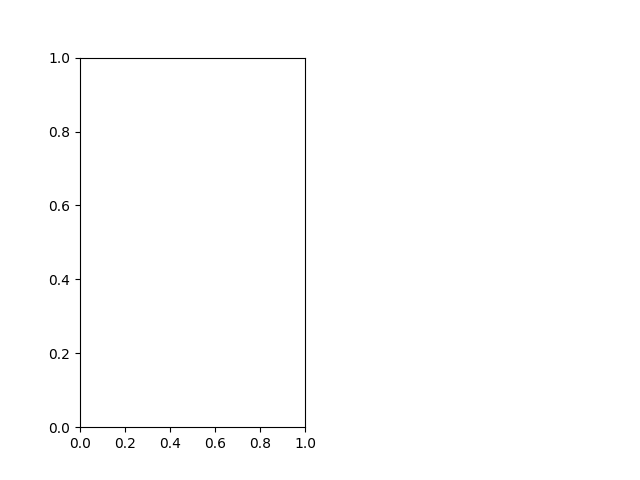

IndexError: index 2 is out of bounds for axis 1 with size 1

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook
v = Spectrogram(256)(Variable(test_loader[0]))
dec = Spectrogram(256)(vae(Variable(test_loader[0])))
plt.subplot(121)
plt.pcolormesh(torch.log(dec).data.numpy()[0,2].T)
plt.subplot(122)
plt.pcolormesh(torch.log(v).data.numpy()[0,2].T)
#plt.plot(vae(v.unsqueeze(0).unsqueeze(0))[0,0].data.numpy()[0:1000])

In [21]:
from torch.nn import Parameter
import torch.optim as optim
import torch
from torch.autograd import Variable
from codes.utility.FFT import FFT
from codes.utility.Spectrogram import Spectrogram

target = (Spectrogram(1*256)(Variable(torch.FloatTensor(sound[20000:208320,0]).unsqueeze(0).unsqueeze(0), requires_grad = False) ))
target_8 = (Spectrogram(16*256)(Variable(torch.FloatTensor(sound[20000:208320,0]).unsqueeze(0).unsqueeze(0), requires_grad = False) ))
target_64 = (Spectrogram(64)(Variable(torch.FloatTensor(sound[20000:208320,0]).unsqueeze(0).unsqueeze(0), requires_grad = False) ))
x = numpy.arange(len(sound[20000:208320,0]))
_input = Variable(torch.FloatTensor(numpy.sin(8/256*numpy.pi*x)).unsqueeze(0).unsqueeze(0), requires_grad = True)

    
train_op = optim.Adam([_input], lr=0.0005)

def _loss(__input, _target, _target_8, _target_64):
    return (Spectrogram(1*256)(__input)).sub(_target).pow(2).sum() + \
        (Spectrogram(16*256)(__input)).sub(_target_8).pow(2).sum() + \
        (Spectrogram(64)(__input)).sub(_target_64).pow(2).sum()
    

for i in range(800):   
    train_op.zero_grad()
    loss = _loss(_input, target, target_8, target_64)
    if i%10==0:
        print(loss.data[0])
    loss.backward()
    train_op.step()          

165555568.0


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


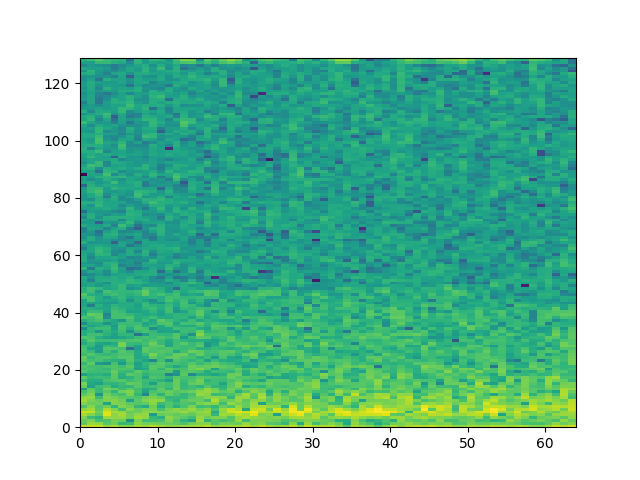

In [42]:
import matplotlib.pyplot as plt
%matplotlib notebook
spec = Spectrogram(256)
plt.pcolormesh(numpy.log(spec(_input)[21,0].data.numpy()))

<IPython.core.display.Javascript object>


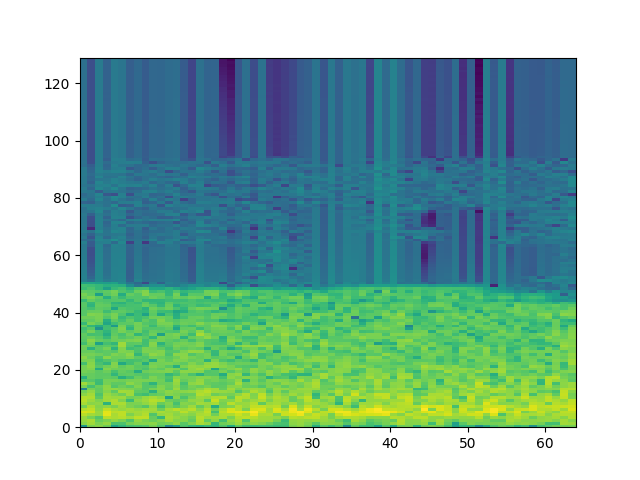

In [43]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.pcolormesh((torch.log(target_256[21,0]).data.numpy()))

In [2]:
import sounddevice as sd
sd.play(_input.data.numpy())

TypeError: Unsupported data type: 'int64'

In [174]:
sd.play(sound[20000:208320,0])

<IPython.core.display.Javascript object>


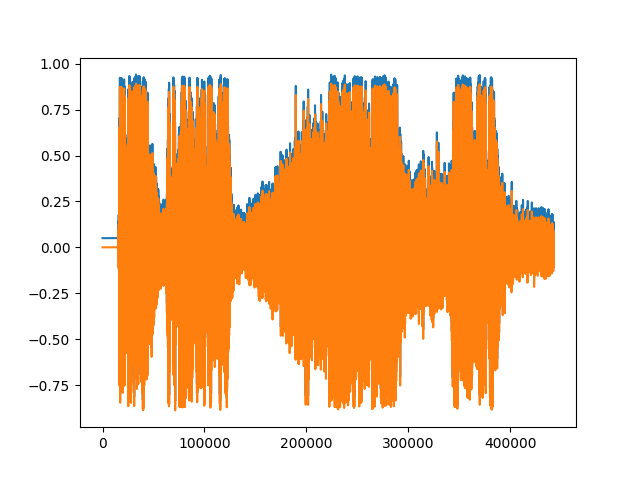

In [13]:
import torch 

def make_batch(sound, chunk_length = 8320, overlap = 128):
    n = numpy.ceil((fs*10-overlap)/(chunk_length-overlap)).astype(int)
    chunks = []
    for i in numpy.arange(n):
        hop = chunk_length - overlap
        chunks.append(torch.FloatTensor(sound[i*hop: i*hop + chunk_length]))

    batch = torch.stack(chunks).unsqueeze(1)
    return batch
    
def stich_batch(batch, overlap = 128):
    result = None
    window = numpy.arange(overlap)/overlap
    for _chunk in batch:
        _chunk_numpy = _chunk[0].numpy()
        if result is None:
            result = _chunk_numpy
        else:
            result[-overlap:] = (1-window)*result[-overlap:] + window*_chunk_numpy[0:overlap]
            result = numpy.concatenate((result, _chunk_numpy[overlap:]))
    
    return result
    
batch = make_batch(sound[:,0])    
result = stich_batch(batch)
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(result+0.05)
plt.plot(sound[0:442496,0])


In [14]:
from torch.autograd import Variable
from codes.utility.Spectrogram import Spectrogram
import torch.optim as optim

target_2048 = Spectrogram(2048)(Variable(batch))
target_256 = Spectrogram(256)(Variable(batch))
target_64 = Spectrogram(64)(Variable(batch))

_input = Variable(torch.Tensor(batch.shape).uniform_(0, 1), requires_grad = True)
train_op = optim.Adam([_input], lr=0.5)

def _loss(__input):
    return ((Spectrogram(1*256)(__input)).sub(target_256).pow(2).sum() + \
           0*(Spectrogram(2048)(__input)).sub(target_2048).pow(2).sum() \
           )/_input.shape[0] 
    

for i in range(0):   
    train_op.zero_grad()
    loss = _loss(_input)
    if i%10==0:
        print(loss.data[0])
    loss.backward()
    train_op.step()

In [46]:
import sounddevice as sd
sd.play(stich_batch(vae(Variable(batch)).data))

<IPython.core.display.Javascript object>


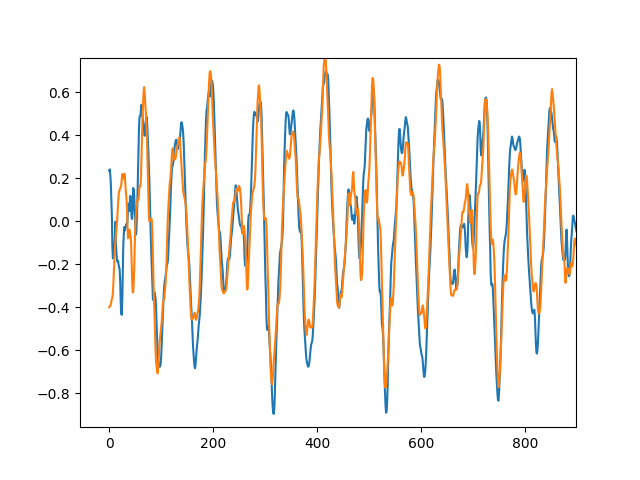

In [176]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(_input.data.numpy()[0:2500])
plt.plot(-sound[20000:208320,0][0:2500])

# Test

In [2]:
import numpy, torch
from torch.autograd import Variable
from codes.utility.Spectrogram import Spectrogram

def get_random_chunk(train = True):
    start = numpy.random.randint(0, int(len(sound[:,0])/2)-8320) if train else \
        numpy.random.randint(int(len(sound[:,0])/2), len(sound[:,0])-8320)
    
    _sound = sound[start:start+8320,0]
    _sound *= 0.9 / numpy.max(numpy.abs(_sound))
    return _sound

train_loader = [] 
test_loader = []
def spec(_in):
    v = torch.pow(Spectrogram(256)(Variable(_in)).data, 1/4.)
    return v/torch.max(v)
for i in range(1):
    train_loader.append(torch.stack([spec(torch.FloatTensor(get_random_chunk())).unsqueeze(0) for i in range(4)]))
for i in range(1):
    test_loader.append(torch.stack([spec(torch.FloatTensor(get_random_chunk(train = False))).unsqueeze(0) for i in range(10)]))

In [3]:
from codes.VAE import VariationalAutoEncoder
from codes.ConvolutionalCoders_129_64.Encoder import Encoder
from codes.ConvolutionalCoders_129_64.Decoder import Decoder
from codes.utility.Spectrogram import Spectrogram

vae = VariationalAutoEncoder(18, 0)
vae.encoder = Encoder(38, 0.2)
vae.decoder = Decoder(38, 0.2)
spec = Spectrogram(256)
vae.train_loader = train_loader
vae.test_loader = test_loader


In [4]:
vae.start()

started False


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


In [76]:
vae.get_progress()[-5:]

[(587, array([45.6711998 , 42.16875458,  3.50244403]), 71.20286865234375),
 (588, array([68.3653183 , 64.30823517,  4.05708647]), 72.34998779296875),
 (589, array([74.17840576, 71.08249664,  3.0959115 ]), 72.59891967773437),
 (590, array([47.07919312, 43.5424118 ,  3.53678036]), 65.01553955078126),
 (591, array([53.36479568, 49.48947144,  3.87532425]), 64.37055053710938)]

<IPython.core.display.Javascript object>


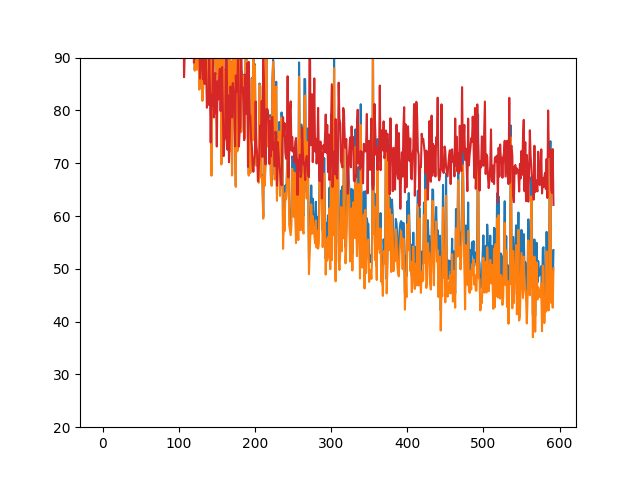

In [77]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ylim(20,90)
plt.plot([i[1] for i in vae.get_progress()])
plt.plot([i[2] for i in vae.get_progress()])

<IPython.core.display.Javascript object>


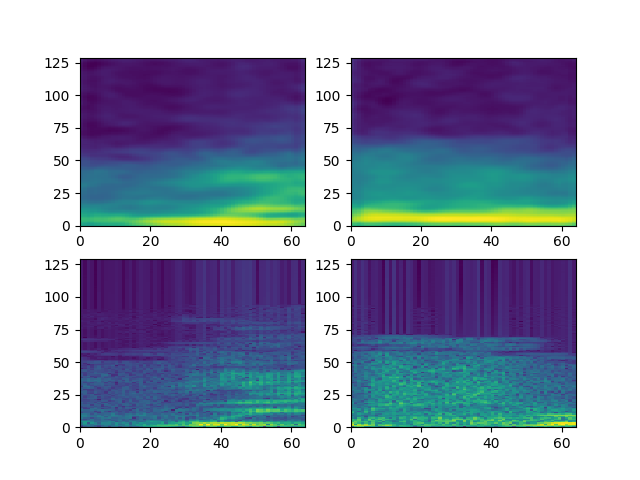

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


In [82]:
import matplotlib.pyplot as plt
%matplotlib notebook

v= Variable(train_loader[0])
plt.subplot(221)
plt.pcolormesh((vae(v[0:1])).data[0,0])
plt.subplot(222)
plt.pcolormesh((vae(v[1:2])).data[0,0])
plt.subplot(223)
plt.pcolormesh(((v[0:1])).data[0,0])
plt.subplot(224)
plt.pcolormesh(((v[1:2])).data[0,0])

In [162]:
loss = []
for i in range(10):
    loss.append(numpy.random.randn(3))

In [166]:
numpy.sum(loss, axis = 0)/

array([-1.58509106, -3.75314878,  0.56758002])